# 短指令辨識

In [ ]:
#!pip install librosa==0.8.1
!pip install librosa

In [1]:
import librosa

print(librosa.__version__)

0.10.2.post1


In [ ]:
# 記得先restart runtime
# 然後進行資料處理
# for colab
from google.colab import drive

drive.mount("/content/drive")

!cp "/content/drive/MyDrive/20230917-Python-第三階段-Sat/chap15.語音處理簡介/GoogleSpeechCommandsDataset.zip" .
!unzip ./GoogleSpeechCommandsDataset.zip

from google.colab import drive

drive.flush_and_unmount()

## 載入相關套件

In [3]:
# 載入相關套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv
import tensorflow as tf
from tensorflow.keras import layers

2024-11-16 15:02:53.499104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 15:02:53.725617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731740573.845210   20304 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731740573.888482   20304 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 15:02:54.221819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
# 不顯示警告訊息
import warnings

warnings.filterwarnings("ignore")

In [5]:
np.__version__

'1.26.4'

## 載入檔案

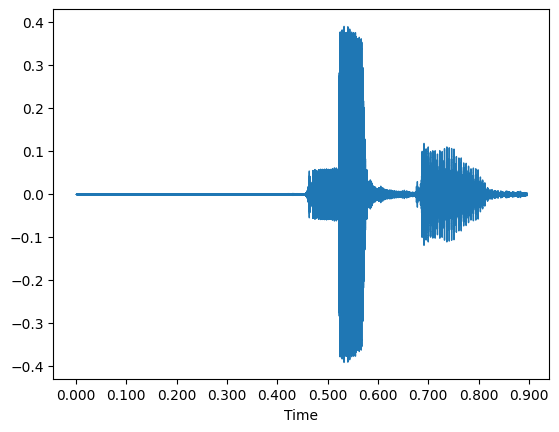

In [5]:
# 任選一檔案測試，發音為 happy
train_audio_path = "./GoogleSpeechCommandsDataset/data/"
data, sr = librosa.load(train_audio_path + "happy/0ab3b47d_nohash_0.wav")

# 繪製波形
# librosa.display.waveplot(data, sr)# 舊版
librosa.display.waveshow(data, sr=sr)
plt.show()
# print(data.shape)

(22050,)


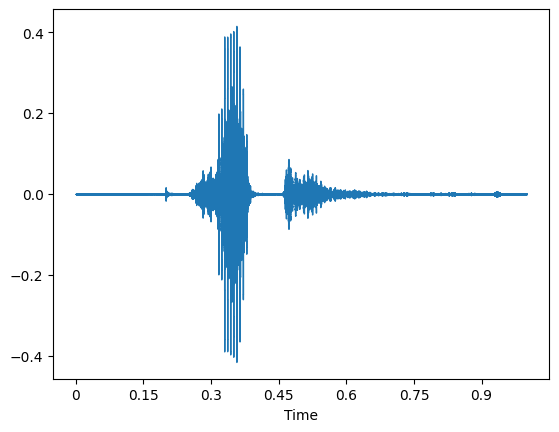

In [6]:
# 任選一檔案測試，發音為 happy
train_audio_path = "./GoogleSpeechCommandsDataset/data/"
data, sr = librosa.load(train_audio_path + "happy/0b09edd3_nohash_0.wav")

# 繪製波形
# librosa.display.waveplot(data, sr)
librosa.display.waveshow(data, sr=sr)
print(data.shape)

In [7]:
# 播放
from IPython.display import Audio

Audio(data, rate=sr)

In [8]:
# 取得音檔的屬性
import wave

wav_file = train_audio_path + "happy/0ab3b47d_nohash_0.wav"
f = wave.open(wav_file)
print(
    f"取樣頻率={f.getframerate()}, 幀數={f.getnframes()}, "
    + f"聲道={f.getnchannels()}, 精度={f.getsampwidth()}, "
    + f"檔案秒數={f.getnframes() / f.getframerate():.2f}"
)
f.close()

nchannels2 = f.getnchannels()
sample_rate2 = f.getframerate()
sample_width2 = f.getsampwidth()

取樣頻率=16000, 幀數=14336, 聲道=1, 精度=2, 檔案秒數=0.90


In [9]:
# 重抽樣，統一取 8000 個樣本
wav_file = train_audio_path + "happy/0ab3b47d_nohash_0.wav"
samples, sample_rate = librosa.load(wav_file, sr=None, res_type="kaiser_fast")
print(f"original sample rate={sample_rate}")
print(f"幀數={len(samples)}")
print(len(samples))

original sample rate=16000
幀數=14336
14336


In [10]:
# 重抽樣，統一取 8000 個樣本
# samples = librosa.resample(samples, sample_rate, 8000)#原
samples = librosa.resample(y=samples, orig_sr=sample_rate, target_sr=8000)
print(f"幀數={len(samples)}")

幀數=7168


In [11]:
samples, sample_rate = librosa.load(wav_file, sr=None, res_type="kaiser_fast")
print(f"original sample rate={sample_rate}")
print(f"幀數={len(samples)}")
new_samples = np.pad(samples, (0, 16000 - len(samples)), "constant")
print(f"幀數={len(new_samples)}")


original sample rate=16000
幀數=14336
幀數=16000


In [12]:
# 重抽樣另一個檔，統一取 8000 個樣本
wav_file = train_audio_path + "bed/0d393936_nohash_0.wav"
samples, sample_rate = librosa.load(wav_file, sr=None, res_type="kaiser_fast")
print(f"original sample rate={sample_rate}")
print(f"幀數={len(samples)}")
# 重抽樣，統一取 8000 個樣本
# samples = librosa.resample(samples, sample_rate, 8000)
samples = librosa.resample(y=samples, orig_sr=sample_rate, target_sr=8000)
print(f"幀數={len(samples)}")

original sample rate=16000
幀數=16000
幀數=8000


In [13]:
samples[:100]

array([-8.1852044e-04, -1.0458997e-03, -8.5876090e-04, -1.0013785e-03,
       -5.8636593e-04, -1.0950023e-03, -3.0509895e-04, -9.0829539e-04,
       -5.7435082e-04, -9.3561539e-04, -5.4565480e-04, -1.0756964e-03,
       -1.1007665e-03, -5.6562771e-05, -7.5910101e-04, -3.2462348e-04,
       -1.8367061e-04,  2.8458919e-04, -1.8148025e-04,  7.4835494e-05,
        7.1050017e-06,  3.8720644e-04,  6.6509523e-04,  1.3869366e-04,
        3.8475360e-04,  1.4766026e-04,  2.5632285e-04,  8.8902161e-06,
        3.8954121e-04,  3.9185336e-04,  7.7149845e-05,  3.3682919e-04,
        5.4696109e-04,  1.0502220e-03,  6.1071233e-04,  1.2466938e-03,
        1.7841174e-03,  2.4926765e-03,  2.2556968e-03,  2.4771313e-03,
        2.5850404e-03,  1.9880193e-03,  2.8127213e-03,  2.3803185e-03,
        2.7394954e-03,  2.7081885e-03,  2.6026038e-03,  2.8948830e-03,
        3.1898948e-03,  2.6484146e-03,  2.4708651e-03,  2.3142362e-03,
        2.1100871e-03,  2.6017430e-03,  2.6482143e-03,  2.7508894e-03,
      

In [14]:
# 取得子目錄名稱
labels = os.listdir(train_audio_path)
labels

['bed', 'cat', 'happy']

檔案數=[1713, 1733, 1742]


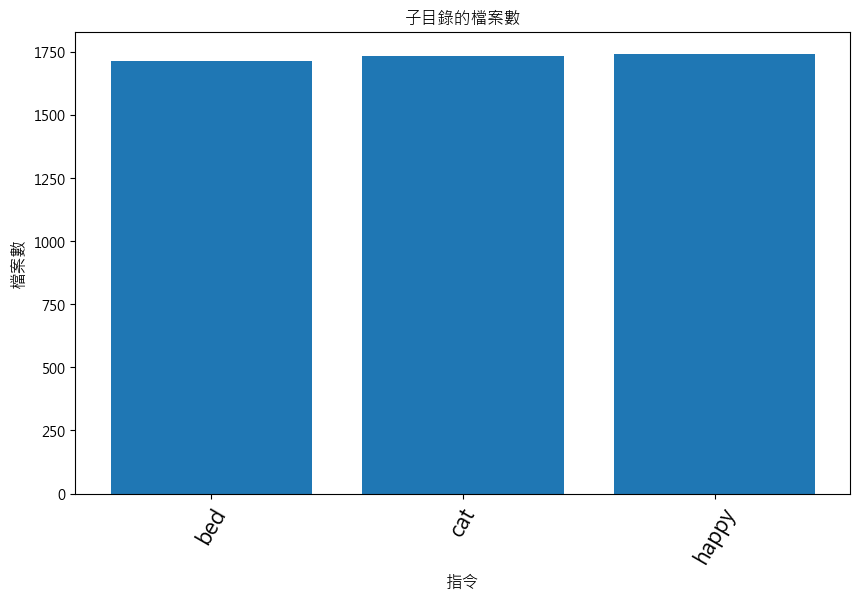

In [16]:
# 子目錄的檔案數
no_of_recordings = []
for label in labels:
    waves = [
        f for f in os.listdir(train_audio_path + "/" + label) if f.endswith(".wav")
    ]
    no_of_recordings.append(len(waves))

# 繪圖
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(10, 6))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel("指令", fontsize=12)
plt.ylabel("檔案數", fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title("子目錄的檔案數")
print(f"檔案數={no_of_recordings}")
plt.show()

(1713, 16000)
(1733, 16000)
(1742, 16000)


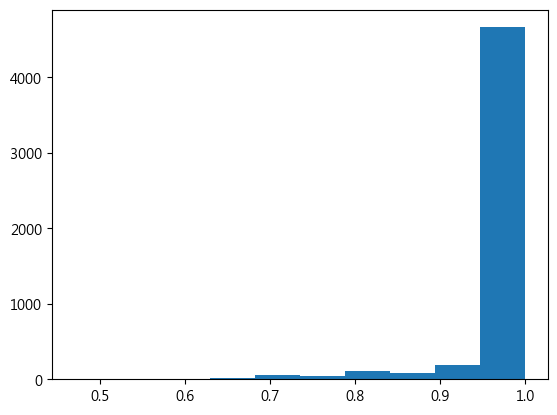

In [17]:
# 載入音樂檔案
TOTAL_FRAME_COUNT = 16000  # 每個檔案統一的幀數
duration_of_recordings = []
all_wave = []
y = []
for i, label in enumerate(labels):
    waves = [
        f for f in os.listdir(train_audio_path + "/" + label) if f.endswith(".wav")
    ]
    class_wave = None
    for wav in waves:
        # 載入音樂檔案
        samples, sample_rate = librosa.load(
            train_audio_path + "/" + label + "/" + wav, sr=None, res_type="kaiser_fast"
        )
        duration_of_recordings.append(float(len(samples) / sample_rate))
        # 長度不足，右邊補 0
        if len(samples) < TOTAL_FRAME_COUNT:
            samples = np.pad(samples, (0, TOTAL_FRAME_COUNT - len(samples)), "constant")
        elif len(samples) > TOTAL_FRAME_COUNT:
            samples = np.resize(samples, TOTAL_FRAME_COUNT)

        if class_wave is None:
            class_wave = samples.reshape(1, -1)
        else:
            class_wave = np.concatenate([class_wave, samples.reshape(1, -1)], axis=0)
        y.append(i)

    all_wave.append(class_wave)
    print(class_wave.shape)
    np.save("./GoogleSpeechCommandsDataset/" + label + ".npy", class_wave)  # 存成 npy
fig = plt.hist(np.array(duration_of_recordings))

In [17]:
# DEBUG Version, 載入音樂檔案
# TOTAL_FRAME_COUNT = 16000 # 每個檔案統一的幀數
# duration_of_recordings=[]
# all_wave = []
# y = []
# good_count_array=[]
# for i, label in enumerate(labels):
#     waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
#     class_wave=None
#     good_count=0
#     for wav in waves:
#         samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav
#                                             ,sr=None , res_type='kaiser_fast')
#         duration_of_recordings.append(float(len(samples)/sample_rate))
#         # 重抽樣，統一取 16000 個樣本
#         # samples = librosa.resample(samples, sample_rate, 8000)
#         if len(samples) < TOTAL_FRAME_COUNT :
#             samples = np.pad(samples,(0, TOTAL_FRAME_COUNT-len(samples)),'constant')
#         elif len(samples) > TOTAL_FRAME_COUNT :
#             samples = np.resize(samples, TOTAL_FRAME_COUNT)
#         if len(samples) != TOTAL_FRAME_COUNT :
#             continue
#         else:
#             good_count+=1

#         if class_wave is None:
#             class_wave = samples.reshape(1, -1)
#         else:
#             class_wave = np.concatenate([class_wave, samples.reshape(1, -1)], axis=0)
#         y.append(i)

#     good_count_array.append(good_count)
#     all_wave.append(class_wave)
#     # 存成 npy
#     print(class_wave.shape)
#     np.save('./GoogleSpeechCommandsDataset/' + label + '.npy', class_wave)
# print(good_count_array)
# fig = plt.hist(np.array(duration_of_recordings))

In [18]:
y[:10], y[-10:]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [19]:
len(all_wave)

3

In [6]:
# 載入npy檔案
train_audio_path2 = "./GoogleSpeechCommandsDataset/"
npy_files = [f for f in os.listdir(train_audio_path2) if f.endswith(".npy")]
print(npy_files)
all_wave = []
y = []
no = 0
for i, label in enumerate(npy_files):
    class_wave = np.load(train_audio_path2 + label)
    all_wave.append(class_wave)
    print(class_wave.shape)
    no += class_wave.shape[0]
    y.extend(np.full(class_wave.shape[0], i))

['happy.npy', 'cat.npy', 'bed.npy']
(1742, 16000)
(1733, 16000)
(1713, 16000)


In [21]:
# 標準化
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# for i in range(len(all_wave)):
#     all_wave[i] = scaler.fit_transform(all_wave[i])

In [7]:
# 計算 MFCC
MFCC_COUNT = 40
X = None
for class_wave in all_wave:
    for data in class_wave:
        # mfcc = librosa.feature.mfcc(y=data, sr=len(data), n_mfcc=MFCC_COUNT)#原
        # 提取特徵
        mfcc = librosa.feature.mfcc(y=data, sr=len(data), n_mfcc=MFCC_COUNT)

        # print(data.shape, mfcc.shape)
        if X is None:
            X = mfcc.reshape(1, MFCC_COUNT, -1, 1)
        else:
            X = np.concatenate((X, mfcc.reshape(1, MFCC_COUNT, -1, 1)), axis=0)
    print(X.shape)
print(X.shape, len(y))

(1742, 40, 32, 1)
(3475, 40, 32, 1)
(5188, 40, 32, 1)
(5188, 40, 32, 1) 5188


In [9]:
np.save("./GoogleSpeechCommandsDataset/mfcc/mfcc.npy", X)
np.save("./GoogleSpeechCommandsDataset/mfcc/y.npy", y)

In [10]:
X = np.load("./GoogleSpeechCommandsDataset/mfcc/mfcc.npy")
y = np.load("./GoogleSpeechCommandsDataset/mfcc/y.npy")
X.shape, y.shape

((5188, 40, 32, 1), (5188,))

In [11]:
# 資料切割
from sklearn.model_selection import train_test_split

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((4150, 40, 32, 1), (1038, 40, 32, 1))

In [14]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(labels), activation="softmax"),
    ]
)

In [15]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# 模型訓練
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# 評分(Score Model)
score = model.evaluate(X_test, y_test, verbose=0)

for i, x in enumerate(score):
    print(f"{model.metrics_names[i]}: {score[i]:.4f}")

Epoch 1/20


I0000 00:00:1731741560.755694   23430 service.cc:148] XLA service 0x7f6588009380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731741560.756286   23430 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-16 15:19:20.795673: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731741560.918926   23430 cuda_dnn.cc:529] Loaded cuDNN version 90300


 51/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3813 - loss: 6.5735

I0000 00:00:1731741563.115939   23430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4586 - loss: 4.5012 - val_accuracy: 0.7819 - val_loss: 0.5846
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7849 - loss: 0.5509 - val_accuracy: 0.8855 - val_loss: 0.3528
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.3914 - val_accuracy: 0.9000 - val_loss: 0.2972
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8866 - loss: 0.3045 - val_accuracy: 0.9289 - val_loss: 0.2363
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9106 - loss: 0.2440 - val_accuracy: 0.9434 - val_loss: 0.1704
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.2269 - val_accuracy: 0.9398 - val_loss: 0.1718
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9355 - loss: 0.1721 - val_accuracy: 0.9506 - val_loss: 0.1523
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.1633 - val_accuracy: 0.9518 - val

## 準確率繪圖

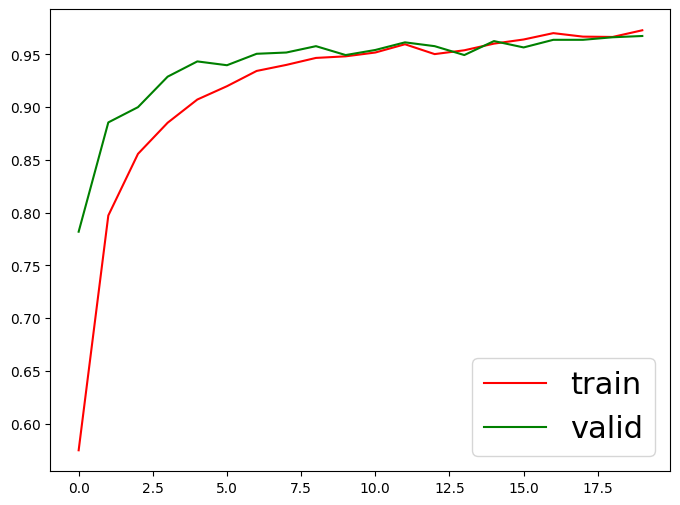

In [16]:
# 對訓練過程的準確率繪圖
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], "r", label="train")
plt.plot(history.history["val_accuracy"], "g", label="valid")
fig = plt.legend(prop={"size": 22})

In [17]:
# 預測函數
def predict(file_path):
    samples, sr = librosa.load(file_path, sr=None, res_type="kaiser_fast")
    # 繪製波形
    librosa.display.waveshow(samples, sr=sr)
    plt.show()

    # 右邊補 0
    if len(samples) < TOTAL_FRAME_COUNT:
        samples = np.pad(samples, (0, TOTAL_FRAME_COUNT - len(samples)), "constant")
    elif len(samples) > TOTAL_FRAME_COUNT:
        # 取中間一段
        oversize = len(samples) - TOTAL_FRAME_COUNT
        samples = samples[int(oversize / 2) : int(oversize / 2) + TOTAL_FRAME_COUNT]

    # 繪製波形
    librosa.display.waveshow(samples, sr=sr)
    plt.show()

    # 驗證 mfcc 是否需要標準化
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=MFCC_COUNT)
    for i in range(mfcc.shape[1]):
        plt.scatter(x=range(mfcc.shape[0]), y=mfcc[:, i].reshape(-1))
    X_pred = mfcc.reshape(1, *mfcc.shape, 1)

    print(X_pred.shape, samples.shape)
    # 預測
    prob = model.predict(X_pred)
    return np.around(prob, 2), labels[np.argmax(prob)]

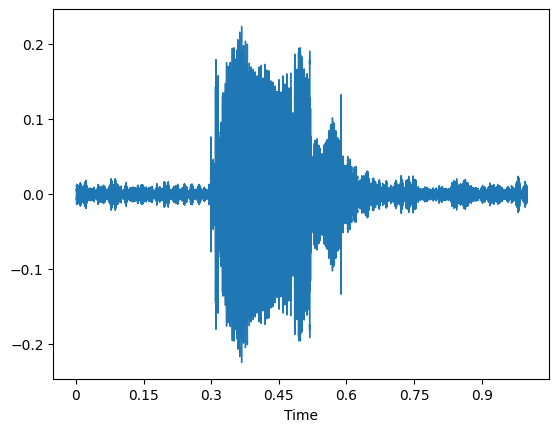

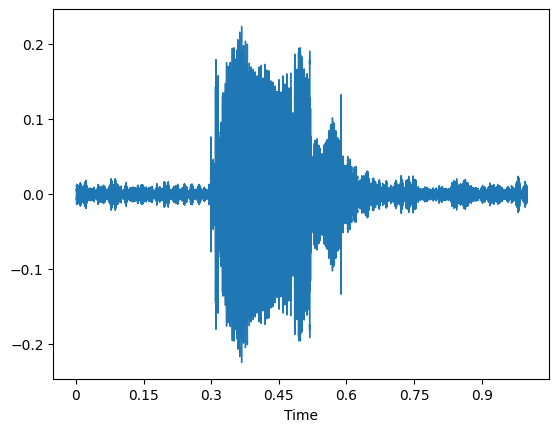

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


(array([[0.  , 0.01, 0.99]], dtype=float32), 'happy')

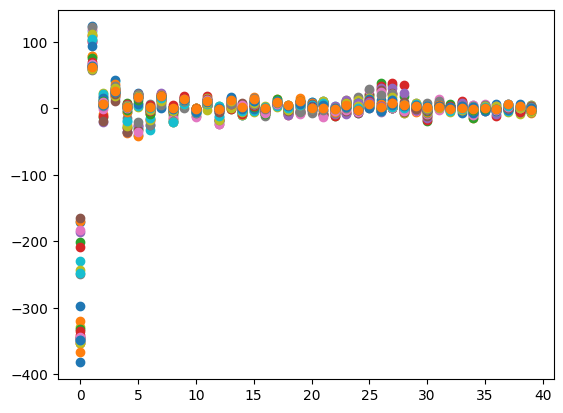

In [21]:
# 任選一檔案測試，該檔案發音為 bed
train_audio_path = "./GoogleSpeechCommandsDataset/data/"
predict(train_audio_path + "bed/0d2bcf9d_nohash_0.wav")

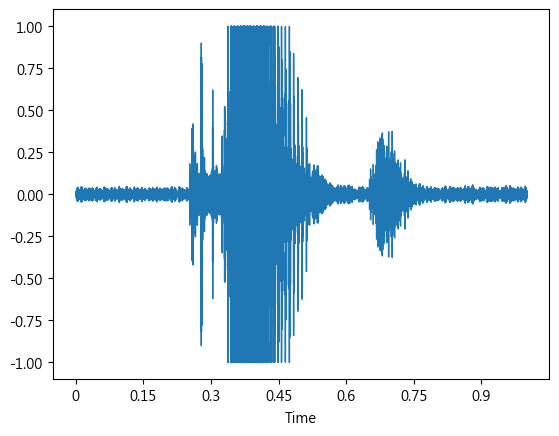

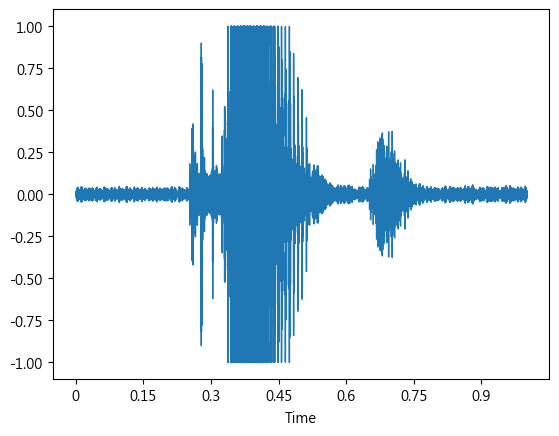

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


(array([[0., 1., 0.]], dtype=float32), 'cat')

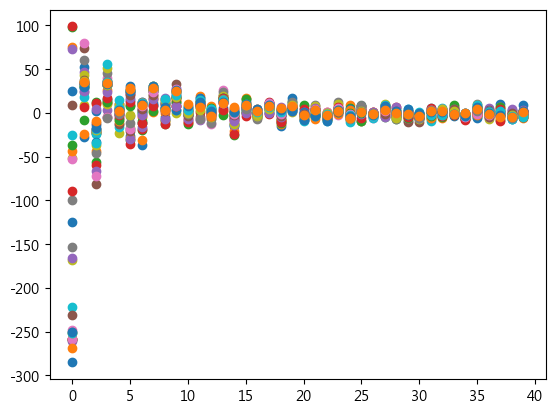

In [31]:
# 任選一檔案測試，該檔案發音為 cat
predict(train_audio_path + "cat/0ac15fe9_nohash_0.wav")

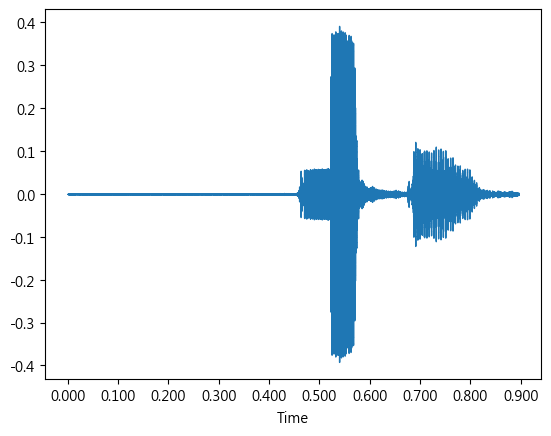

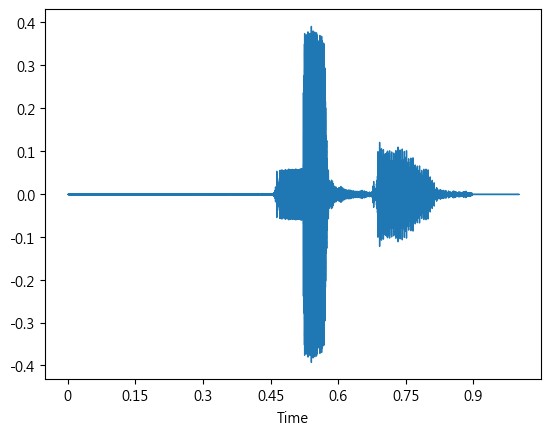

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(array([[0., 0., 1.]], dtype=float32), 'happy')

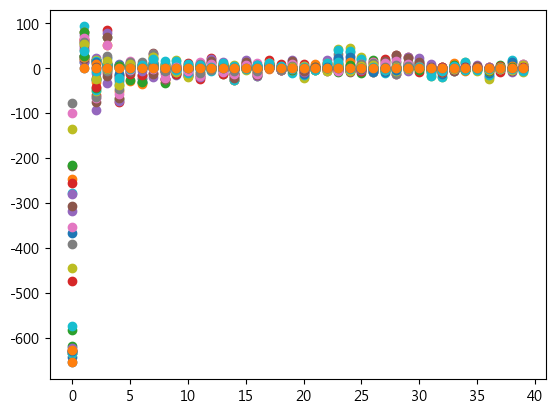

In [32]:
# 任選一檔案測試，該檔案發音為 happy
predict(train_audio_path + "happy/0ab3b47d_nohash_0.wav")

## 自行使用 14_10_record.py 錄音，指令：
python 14_10_record.py GoogleSpeechCommandsDataset/happy.wav

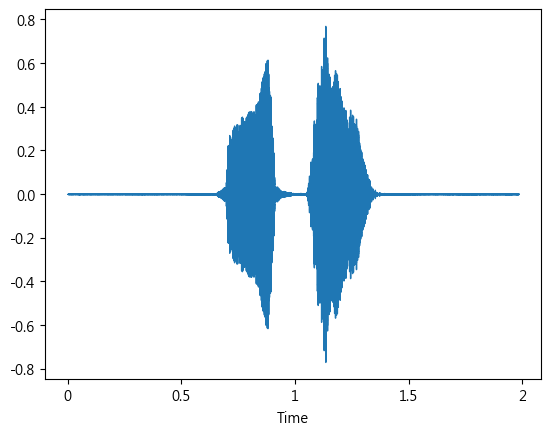

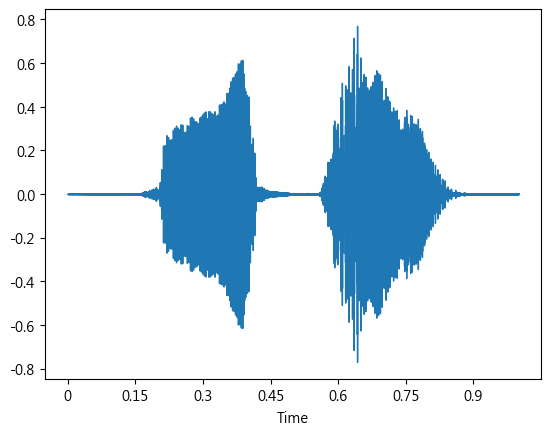

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(array([[1., 0., 0.]], dtype=float32), 'bed')

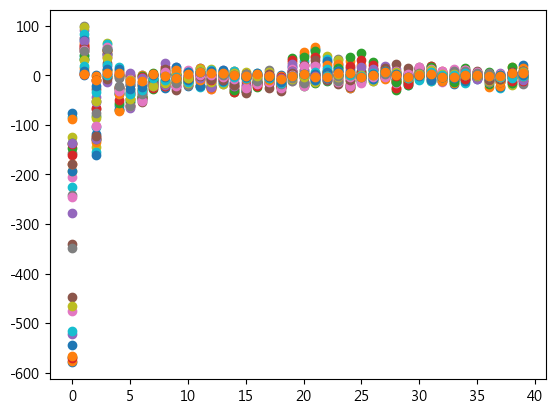

In [33]:
# 測試，該檔案發音為 happy
predict("./GoogleSpeechCommandsDataset/happy.wav")

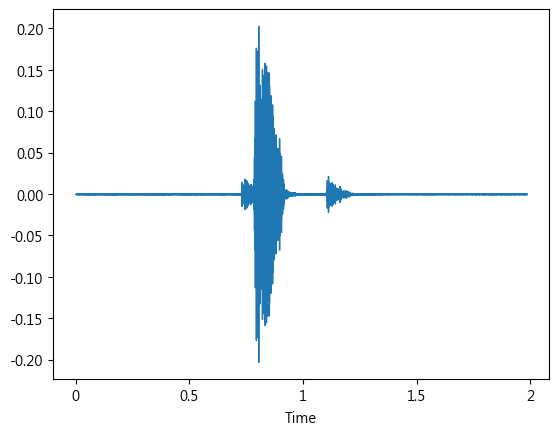

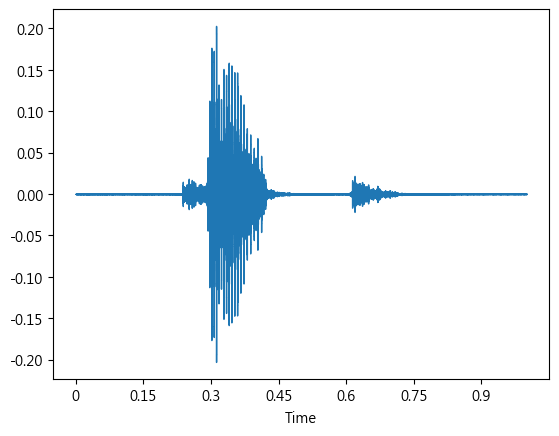

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


(array([[0.92, 0.08, 0.  ]], dtype=float32), 'bed')

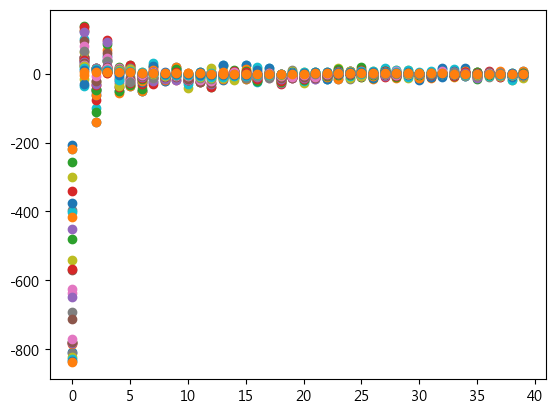

In [34]:
# 測試，該檔案發音為 cat
predict("./GoogleSpeechCommandsDataset/cat.wav")

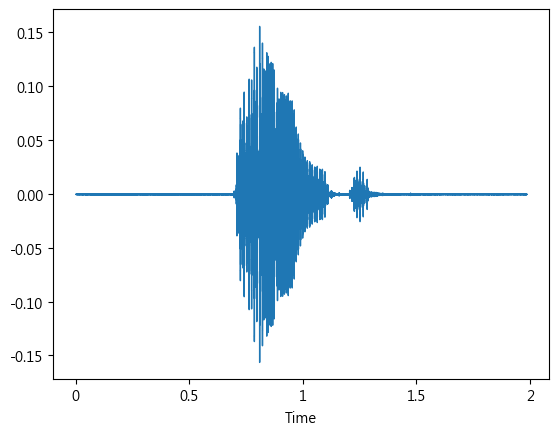

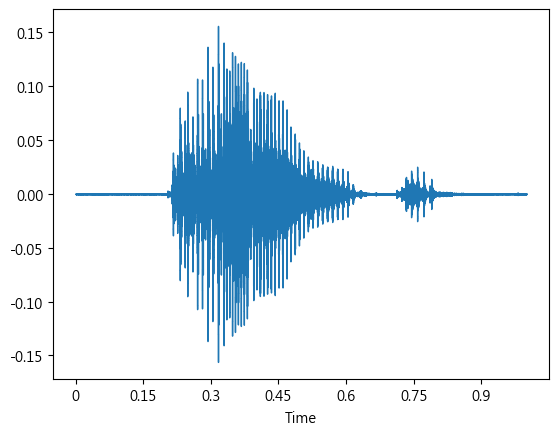

(1, 40, 32, 1) (16000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(array([[1., 0., 0.]], dtype=float32), 'bed')

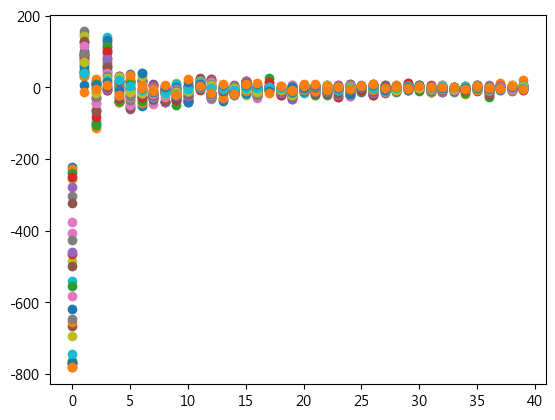

In [35]:
# 測試，該檔案發音為 bed
predict("./GoogleSpeechCommandsDataset/bed.wav")